# Projeto 01: Reconhecimento de Dígitos

### João Victor Soares Silva | Mat: 20210027300
### Yhasmim de Souza Tigre | Mat: 20210026966 

## Pré-Processamento

In [1]:
from copy import copy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from Algoritmos import *

In [2]:
N = 28 #Número de linhas e colunas das matrizes das imagens
P_MAX = 255 #Número máximo de um pixel

In [3]:
def reduzir (nome : str, arq : str) -> None:

    """Essa função calcula as simetria e a intensidade dos pixels e
       cria um novo arquivo reduzido a partir do arquivo original.
       
       parametros:
       nome : str -> Nome do novo arquivo
       arq : str -> Nome do arquivo original
       
       return: None
    """

    #variavel de auxilio para receber os dados do arquivo
    aux = np.loadtxt (arq, delimiter = ';', dtype = str)
    aux = np.delete (aux, 0, 0) #Removendo a linha dos nomes das colunas

    #iniciando as listas
    lista_y = []
    lista_intensidade = []
    lista_simetria_vertical = []
    lista_simetria_horizontal = []
    lista_simetria = []

    for i in range (len(aux)): #Salvando as labels
        lista_y.append (int(aux[i][0]))
    
    aux = np.delete (aux, 0, 1) #Removendo as labels
    
    for i in range (len(aux)): #Calculando as intensidades
        soma = 0

        for j in range (len(aux[0])):
            soma += int(aux[i][j])
        
        lista_intensidade.append(soma/P_MAX)
    
    for imagem in aux: #Simetria vertical
        soma = 0

        for i in range(N): #percorre linhas
            for j in range(int(N/2)): #percorre colunas
                soma += abs(int(imagem[(N*i) + j]) - int(imagem[(N*i) + (N - j - 1)]))

        lista_simetria_vertical.append(soma/P_MAX)

    for imagem in aux: #Simetria horizontal
        soma = 0

        for i in range(int(N/2)): #percorre linhas
            for j in range(N): #percorre colunas
                soma += abs(int(imagem[(N*i) + j]) - int(imagem[N * (N - i - 1) + j]))

        lista_simetria_horizontal.append(soma/P_MAX)
    
    for i in range (len(aux)): #Somando as simetrias
        lista_simetria.append(lista_simetria_vertical[i] + lista_simetria_horizontal[i])

    #Criando e preenchendo o novo .csv
    dados_redux = open (f'{nome}.csv', 'w')

    dados_redux.write ('label;intensidade;simetria\n')
    for i in range (len(aux)):
        dados_redux.write (f'{lista_y[i]};{lista_intensidade[i]};{lista_simetria[i]}\n')
    
    dados_redux.close()

    return

In [4]:
#Reduzindo as dimensões:

reduzir(nome = 'train_redu', arq = 'train.csv')
reduzir(nome = 'test_redu', arq = 'test.csv')

## Funções

#### Auxiliares

In [5]:
def mod_labels (X : np.array, Y : np.array, labels : list) -> np.array:

    """Essa função filtra os valores de Y (labels do arquivo) para que sejam 1 e -1.
    
       parametros:
       X : np.array -> Array com as informações dos pixels
       Y : np.array -> Array com as labels
       labels : list -> Lista com as labels que deverão ser classificadas
       
       return: np.array
    """

    if (len(labels) != 2):
        print("Selecione as duas labels que deverão ser classificadas.")

        return None

    novo_X = []
    novo_Y = []

    for i in range (len(Y)):
        if (Y[i] == labels[0]):
            novo_X.append(X[i])
            novo_Y.append(1)
        
        elif (Y[i] == labels[1]):
            novo_X.append(X[i])
            novo_Y.append(-1)
    
    return np.array(novo_X), np.array(novo_Y)

In [6]:
def normalizar (x : np.array) -> np.array:
    """ Essa função padroniza os valores de x. A normalização usada
        é a z-score (para dados com distribuição normal). Transforma
        todas as variáveis na mesma ordem de grandeza.

        parametros:
        x : np.array -> Array com os valores a serem normalizados

        return: np.array
    """
    media = np.mean(x)
    desvio = np.std(x)

    return ((x - media) / desvio)

Separando as features e as labels dos dados de treino e teste

In [7]:
#Instanciando dados gerais:

#Treino:
train = pd.read_csv("train_redu.csv", sep = ";")
train[['intensidade', 'simetria']] = train[['intensidade', 'simetria']].apply(normalizar)
X_train = train[['intensidade', 'simetria']].to_numpy(dtype = float)
y_train = train['label'].to_numpy(dtype = float)

#Teste:
test = pd.read_csv("test_redu.csv", sep = ";")
test[['intensidade', 'simetria']] = test[['intensidade', 'simetria']].apply(normalizar)
X_test = test[['intensidade', 'simetria']].to_numpy(dtype = float)
y_test = test['label'].to_numpy(dtype = float)

#### De Visualização

In [8]:
def plot_alg_1x5 (w_lista : np.array, dados_df : pd.DataFrame) -> None:

    """Função que cria um gráfico de dispersão com os dígitos 1 e 5
        e a reta que separa as duas classes.
         
         parametros:
         w_lista : np.array -> Lista com os pesos do algoritmo
         dados_df : pd.DataFrame -> DataFrame com os dados dos dígitos
         
         return: None
    
    """
    digitos_df = dados_df.loc[dados_df['label'].isin([1, 5])]
    sns.set_theme() #determina o tema do gráfico
    
    sns.jointplot(data = digitos_df, x = "intensidade", y = "simetria", hue = "label", palette = "Set2") 

    #plotando a reta de acordo com os pesos
    r = np.linspace(-3, 3, 10)
    #equação da reta: w0 + w1*x + w2*y = 0
    plt.plot(r, (-w_lista[0] - w_lista[1]*r) / w_lista[2], c = 'lightseagreen')
    
    #limites do gráfico para centralizar o plot
    plt.ylim(-3, 3)
    plt.xlim(-3, 3)
    plt.show()

    return None

In [9]:
def plot_alg_1vTodos (w_lista : np.array, dados_df : pd.DataFrame) -> None:

    """Função que cria um gráfico de dispersão para todos os digitos
        e a reta que separa as duas classes.
         
         parametros:
         w_lista : np.array -> Lista com os pesos do algoritmo
         dados_df : pd.DataFrame -> DataFrame com os dados dos dígitos
         
         return: None

    """
    digitos_df = dados_df
    sns.set_theme()
    sns.jointplot(data = digitos_df, x = "intensidade", y = "simetria", hue = "label", palette = "Set2") 
    
    reta_lista = []
    for i in range (len(w_lista)):
        reta_lista.append(np.linspace(-3, 3, 10))

    cor_lista = ['lightseagreen', 'cornflowerblue', 'mediumorchid']
    for w, c, r in zip (w_lista, cor_lista, reta_lista):
        #equação da reta: w0 + w1*x + w2*y = 0
        plt.plot(r, (-w[0] - w[1]*r) / w[2], c = c)
    
    #limites do gráfico para centralizar o plot
    plt.ylim(-3, 3)
    plt.xlim(-3, 3)
    plt.show()

    return None

In [10]:
def plot_relatorio_eff_1x5 (Y_pred : np.array, Y_real : np.array) -> None:
    """ Função que plota a matriz de confusão e o relatório de eficácia
        para os dígitos 1 e 5.
        
        parametros:
        Y_pred : np.array -> Array com as predições do algoritmo
        Y_real : np.array -> Array com os valores reais
        
        return: None
    
    """
    
    print("Relatório de Eficácia:\n\n" + classification_report(y_true = Y_real, y_pred = Y_pred))

    #Matriz de Confusão
    mat_con = confusion_matrix (y_true = Y_real, y_pred = Y_pred)
    ax = sns.heatmap(mat_con, annot = True, fmt = 'd')

    ax.set_xlabel("Classificação Prevista", fontsize = 14, labelpad = 20)
    ax.xaxis.set_ticklabels(['Negativo', 'Positivo'])
    
    ax.set_ylabel("Classificação Real", fontsize = 14, labelpad = 20)
    ax.yaxis.set_ticklabels(['Negativo', 'Positivo'])
    
    ax.set_title("Matriz de Confusão", fontsize = 14, pad = 20)

    plt.show()

    return None

In [11]:
def plot_relatorio_eff_1vTodos (Y_pred : np.array, Y_real : np.array, ordem : list) -> None:
    """ Função que plota a matriz de confusão e o relatório de eficácia
        para todos os dígitos.
        
        parametros:
        Y_pred : np.array -> Array com as predições do algoritmo
        Y_real : np.array -> Array com os valores reais
        ordem : list -> Lista com a ordem dos dígitos
        
        return: None
    """
    
    print("Relatório de Eficácia:\n\n" + classification_report(y_true = Y_real, y_pred = Y_pred))

    #Matriz de Confusão
    mat_con = confusion_matrix (y_true = Y_real, y_pred = Y_pred)
    ax = sns.heatmap(mat_con, annot = True, fmt = 'd')

    ax.set_xlabel("Classificação Prevista", fontsize = 14, labelpad = 20)
    ax.xaxis.set_ticklabels(ordem)
    
    ax.set_ylabel("Classificação Real", fontsize = 14, labelpad = 20)
    ax.yaxis.set_ticklabels(ordem)
    
    ax.set_title("Matriz de Confusão", fontsize = 14, pad = 20)

    plt.show()

    return None

## Classificação dos Dígitos 1x5

In [12]:
#Instanciando para o problema:

X_train_1x5, y_train_1x5 = mod_labels (X = X_train, Y = y_train, labels = [1, 5])
X_test_1x5, y_test_1x5 = mod_labels (X = X_test, Y = y_test, labels = [1, 5])

### Perceptron Learning Algorithm (PLA)

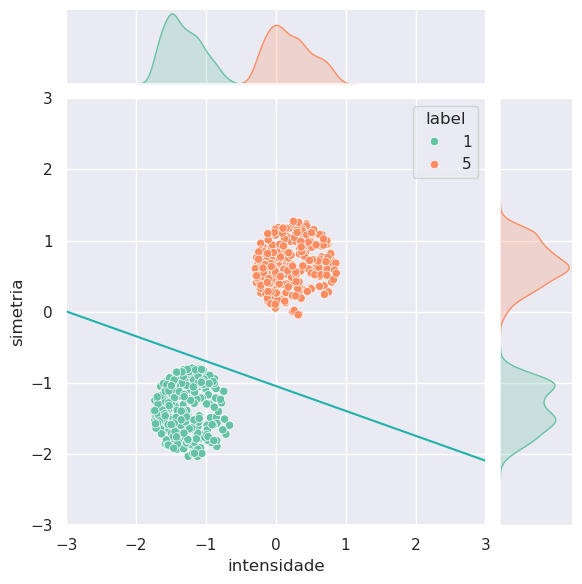

In [13]:
#Instanciando o objeto:
PLA_1x5 = PLA (n_int = 1000)

#Treinando:
PLA_1x5.fit(X = X_train_1x5, Y = y_train_1x5)

#Obtendo os pesos:
PLA_w_1x5 = PLA_1x5.get_w()

#Observando no gráfico:
plot_alg_1x5 (w_lista = PLA_w_1x5, dados_df = test)

Relatório de Eficácia:

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       291
           1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583



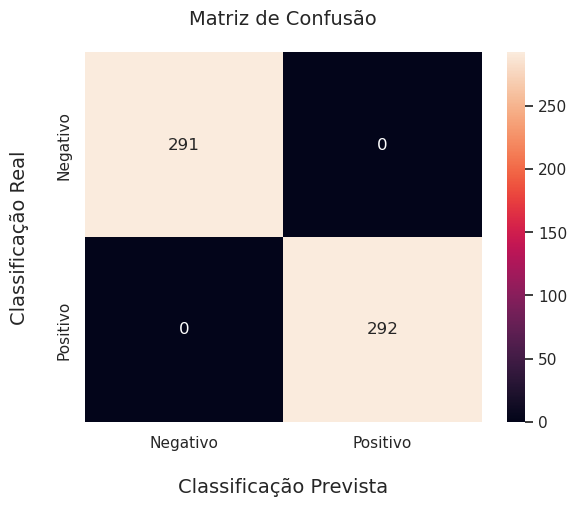

In [14]:
plot_relatorio_eff_1x5 (Y_pred = PLA_1x5.predict(X = X_test_1x5), Y_real = y_test_1x5)

### Regressão Linear

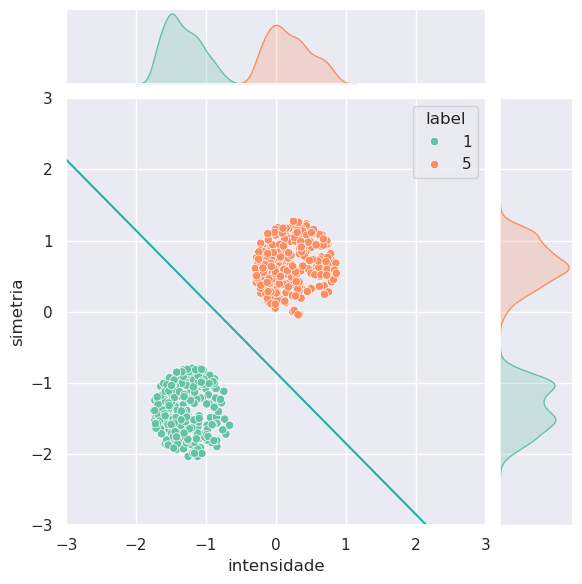

In [15]:
#Instanciando o objeto:
Rlin_1x5 = Reg_Lin ()

#Treinando:
Rlin_1x5.fit(X = X_train_1x5, Y = y_train_1x5)

#Obtendo os pesos:
Rlin_w_1x5 = Rlin_1x5.get_w()

#Observando no gráfico:
plot_alg_1x5 (w_lista = Rlin_w_1x5, dados_df = test)

Relatório de Eficácia:

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       291
           1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583



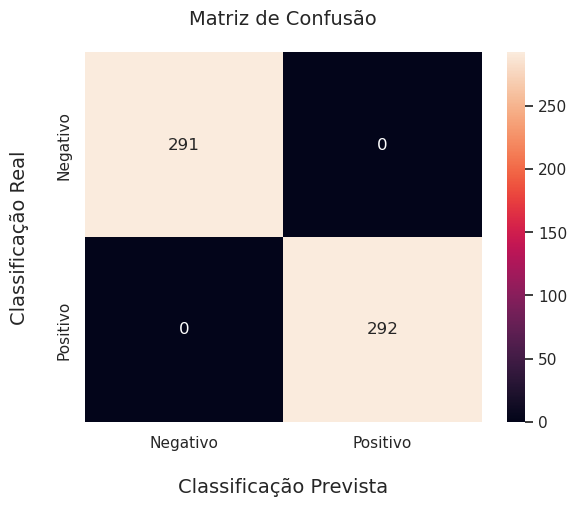

In [16]:
plot_relatorio_eff_1x5 (Y_pred = Rlin_1x5.predict(X = X_test_1x5), Y_real = y_test_1x5)

### Regressão Logística

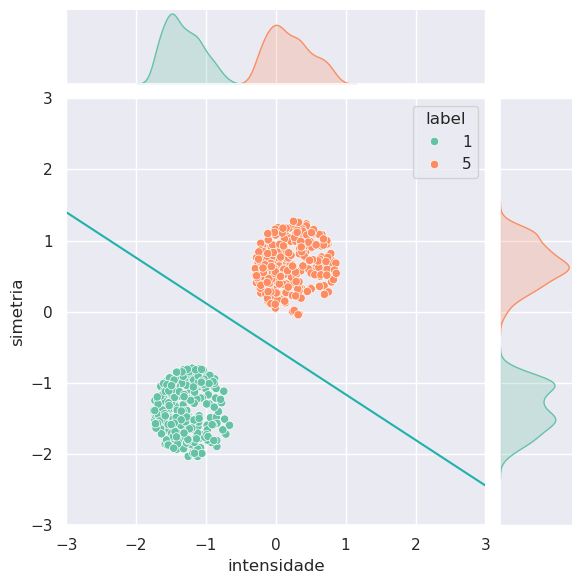

In [17]:
#Instanciando o objeto:
Rlog_1x5 = Reg_Log (n_int = 1000, tam_batch = 50)

#Treinando:
Rlog_1x5.fit(X = X_train_1x5, Y = y_train_1x5)

#Obtendo os pesos:
Rlog_w_1x5 = Rlog_1x5.get_w()

#Observando no gráfico:
plot_alg_1x5 (w_lista = Rlog_w_1x5, dados_df = test)

Relatório de Eficácia:

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       291
           1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583



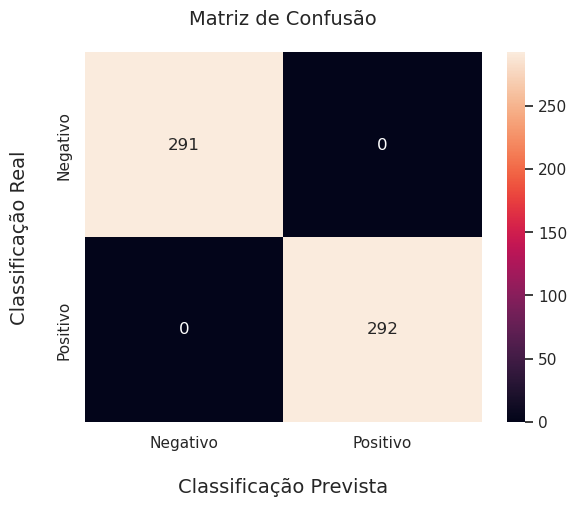

In [18]:
plot_relatorio_eff_1x5 (Y_pred = Rlog_1x5.predict(X = X_test_1x5), Y_real = y_test_1x5)

### Discussão dos Resultados

- Podemos observar que os dígitos 1 e 5, com esses parâmetros, ficam fortemente concentrados em suas respectivas vizinhanças no gráfico; 
- Todos os modelos conseguiram alcançar 100% de acurácia, devido aos dígitos 1 e 5 serem linearmente separáveis. Assim, nenhum modelo se sobressaiu quanto a resultados nesse teste;

## Classificação de Dígitos Completo

In [19]:
#Ordem utilizada:

ordem_1vTodos = [0, 1, 4, 5]

### Algoritmo UmVSTodos

In [34]:
class UmVSTodos ():
    def __init__ (self, ordem : list, n_int : int = 1000, modelo = None) -> None:

        """Essa função realiza a classificação de um contra todos, fazendo a previsão
           para casa classe comparando com as demais.
           
           parametros:
           ordem : list -> Lista com a ordem das labels
           n_int : int -> Número de iterações
           modelo : class -> Modelo de classificação
           
           return: None
        """

        self.modelo = modelo(n_int = n_int)
        self.ordem = ordem
        self.w_lista = [0 for i in range (len(ordem) - 1)]
    
    def acuracia (self, X : np.array, Y : np.array) -> float:
        soma_PCC = 0
        y_predict = self.predict(X = X)

        for y_pred, y_real in zip (y_predict, Y):
            if (y_pred == y_real):
                soma_PCC += 1
        
        return (soma_PCC/len(X))
        
    def fit (self, X : np.array, Y : np.array) -> None:
        novo_X = X
        novo_Y = Y

        fila = copy(self.ordem)
        self.w_lista = []

        while (len(fila) > 1):
            Y_temp = []
            index_lista = []

            #Adequando as labels
            for i in range(len(novo_Y)):
                if (novo_Y[i] == fila[0]):
                    Y_temp.append(1)
                    index_lista.append(i)
                
                else:
                    Y_temp.append(-1)
            
            #Treinando os pesos de acordo com o modelo
            self.modelo.fit(X = novo_X, Y = Y_temp)
            self.w_lista.append(self.modelo.get_w())

            #Atualizando as listas, removendo as labels já treinadas
            novo_X = np.delete (novo_X, index_lista, axis = 0)
            novo_Y = np.delete (novo_Y, index_lista)
            fila.remove(fila[0])

        return
    
    def predict (self, X : np.array) -> np.array:
        lista_X = X
        y_predict = np.zeros(len(X), dtype = float)
        aux_ind = np.array([int(i) for i in range (len(X))]) #lista para localizar os indexes originais de cada x

        #Percorrendo os classificadores:
        for i in range (len(self.w_lista)): #[ws(0 v todos ), ws(1 vs 4/5) , ws(4v5)]
            self.modelo.set_w (novo_w = self.w_lista[i])
            y_temp = self.modelo.predict(X = lista_X) #(1 ou -1)
            class_ind = [] #indexes classificados

            for j in range (len(y_temp)):
                if (y_temp[j] == 1):
                    y_predict[aux_ind[j]] = self.ordem[i] #Ordem = [0, 1, 4, 5]
                    class_ind.append(j)

            #Removendo os pontos já classificados:
            lista_X = np.delete (lista_X, class_ind, axis = 0)
            aux_ind = np.delete (aux_ind, class_ind)       

        #Aquele que não foi identificado como +1 em nenhum momento, percente à última label da ordem:
        for k in aux_ind:
            y_predict[k] = self.ordem[-1]    
        
        return y_predict #[0, 1, 4 ou 5]                   
    
    def get_w (self) -> np.array:
        try:
            return self.w_lista
        
        except:
            print("Não foi possível recuperar w. Por favor, se certifique de treinar o modelo antes.\n")
    
    def set_ordem (self, nova_ordem : list) -> None:
        self.ordem = nova_ordem

### Perceptron Learning Algorithm (PLA)

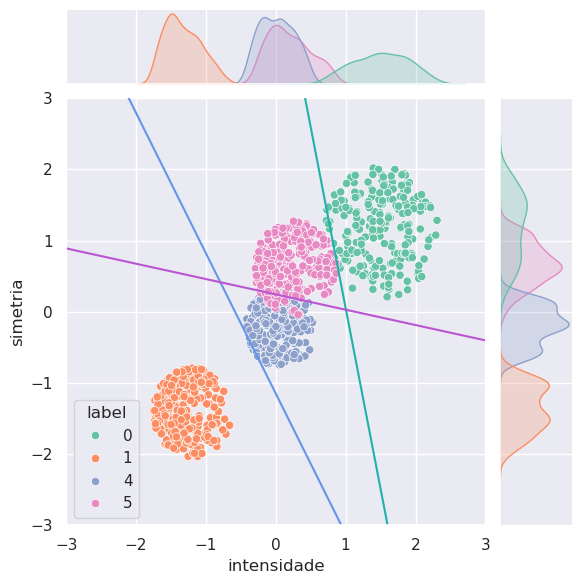

In [21]:
#Instanciando o objeto:
PLA_1vTodos = UmVSTodos (ordem = ordem_1vTodos, n_int = 1000, modelo = PLA)

#Treinando:
PLA_1vTodos.fit(X = X_train, Y = y_train)

#Obtendo os pesos:
PLA_w_1vTodos = PLA_1vTodos.get_w()

#Observando no gráfico:
plot_alg_1vTodos (w_lista = PLA_w_1vTodos, dados_df = test)

Relatório de Eficácia:

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98       218
         1.0       0.99      1.00      1.00       292
         4.0       0.94      0.94      0.94       314
         5.0       0.92      0.93      0.93       291

    accuracy                           0.96      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.96      0.96      0.96      1115



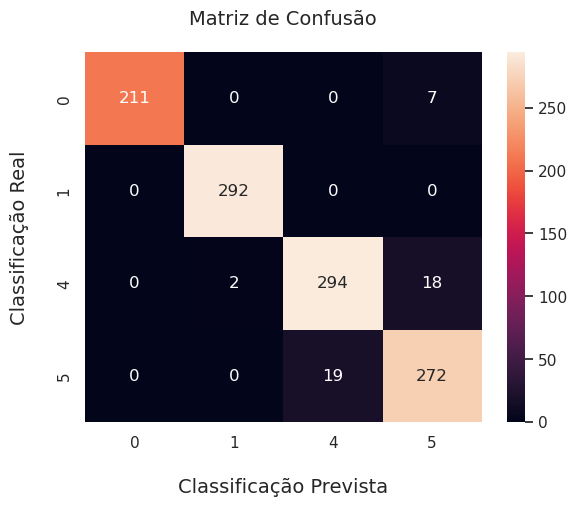

In [22]:
plot_relatorio_eff_1vTodos (Y_pred = PLA_1vTodos.predict(X = X_test), Y_real = y_test, ordem = ordem_1vTodos)

### Regressão Linear

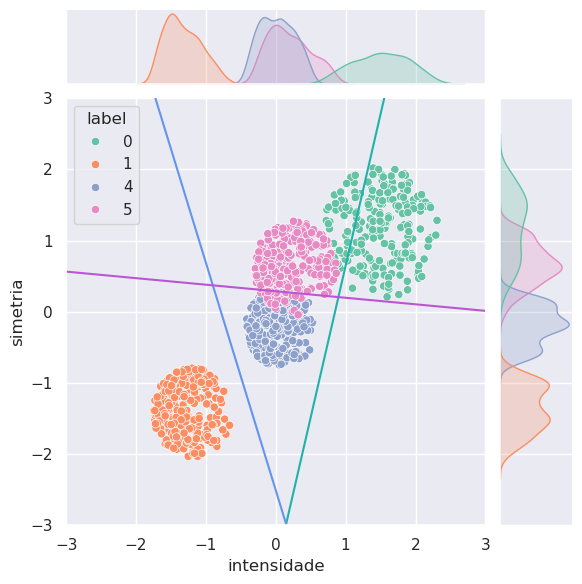

In [23]:
#Instanciando o objeto:
Rlin_1vTodos = UmVSTodos (ordem = ordem_1vTodos, n_int = 1000, modelo = Reg_Lin)

#Treinando:
Rlin_1vTodos.fit(X = X_train, Y = y_train)

#Obtendo os pesos:
Rlin_w_1vTodos = Rlin_1vTodos.get_w()

#Observando no gráfico:
plot_alg_1vTodos (w_lista = Rlin_w_1vTodos, dados_df = test)

Relatório de Eficácia:

              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89       218
         1.0       1.00      1.00      1.00       292
         4.0       0.92      0.99      0.95       314
         5.0       0.85      0.90      0.87       291

    accuracy                           0.93      1115
   macro avg       0.94      0.92      0.93      1115
weighted avg       0.94      0.93      0.93      1115



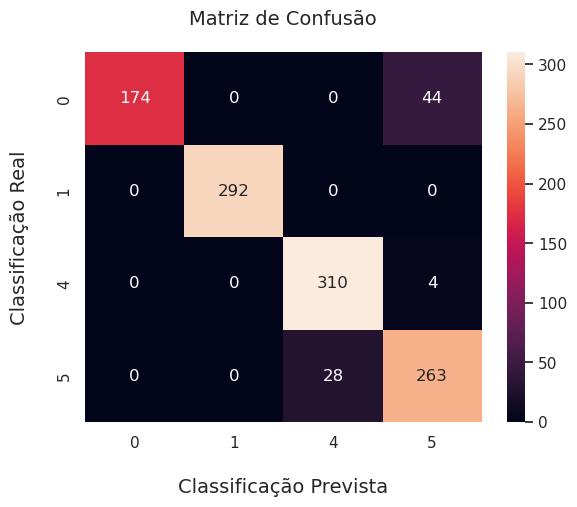

In [24]:
plot_relatorio_eff_1vTodos (Y_pred = Rlin_1vTodos.predict(X = X_test), Y_real = y_test, ordem = ordem_1vTodos)

### Regressão Logística

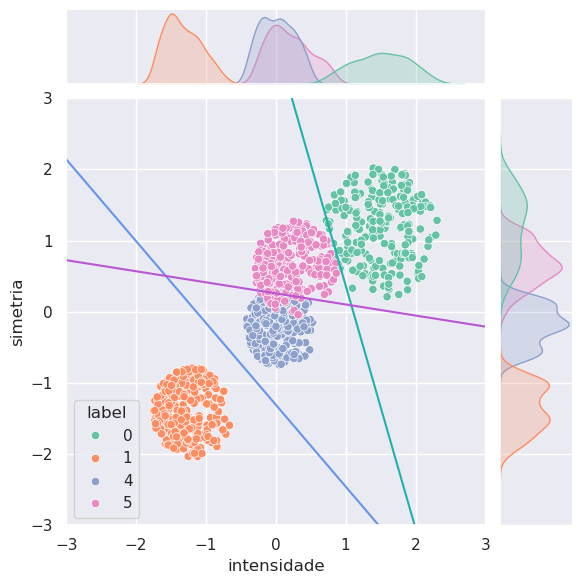

In [25]:
#Instanciando o objeto:
Rlog_1vTodos = UmVSTodos (ordem = ordem_1vTodos, n_int = 1000, modelo = Reg_Log)

#Treinando:
Rlog_1vTodos.fit(X = X_train, Y = y_train)

#Obtendo os peso
Rlog_w_1vTodos = Rlog_1vTodos.get_w()

#Observando no gráfico:
plot_alg_1vTodos (w_lista = Rlog_w_1vTodos, dados_df = test)

Relatório de Eficácia:

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98       218
         1.0       1.00      1.00      1.00       292
         4.0       0.94      0.96      0.95       314
         5.0       0.93      0.93      0.93       291

    accuracy                           0.96      1115
   macro avg       0.97      0.96      0.96      1115
weighted avg       0.96      0.96      0.96      1115



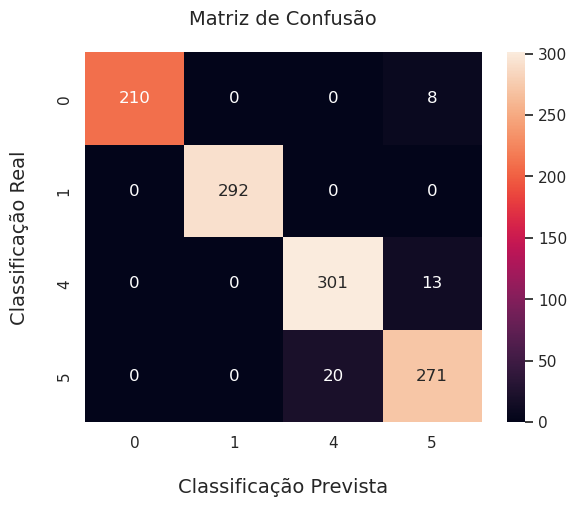

In [26]:
plot_relatorio_eff_1vTodos (Y_pred = Rlog_1vTodos.predict(X = X_test), Y_real = y_test, ordem = ordem_1vTodos)

### Discussão dos Resultados

- Podemos observar que os dígitos 0 e 5 não podem ser linearmente separáveis por esses parâmetros, mas que os conjuntos possuem pouca sobreposição, levando a poucos erros;
- Os conjuntos dos dígitos 4 e 5 possuem maior sopreposição e são os conjuntos em que os classificadores tiverem os piores resultados;
- Todos os algoritmos alcançaram resultados similares. 

## Implementações Avançadas

### Definindo a Melhor Ordem

In [28]:
ordens_possiveis = [[0, 1, 4, 5], [0, 1, 5, 4], [0, 4, 1, 5], [0, 4, 5, 1], [0, 5, 1, 4], [0, 5, 4, 1],
                    [1, 0, 4, 5], [1, 0, 5, 4], [1, 4, 0, 5], [1, 4, 5, 0], [1, 5, 0, 4], [1, 5, 4, 0],
                    [4, 1, 0, 5], [4, 1, 5, 0], [4, 0, 1, 5], [4, 0, 5, 1], [4, 5, 1, 0], [4, 5, 0, 1],
                    [5, 1, 4, 0], [5, 1, 0, 4], [5, 4, 1, 0], [5, 4, 0, 1], [5, 0, 1, 4], [5, 0, 4, 1]]

#### PLA

In [37]:
Acc_PLA = []

for o in ordens_possiveis:
    Comp_PLA = UmVSTodos (ordem = o, n_int = 1000, modelo = PLA)
    Comp_PLA.fit(X = X_train, Y = y_train)
    Acc_PLA.append([o, Comp_PLA.acuracia (X = X_test, Y = y_test)])

PLA_df = pd.DataFrame(data = Acc_PLA, columns = ["ordem", "acurácia"])
PLA_df

,ordem,acurácia
0,"[0, 1, 4, 5]",0.958744
1,"[0, 1, 5, 4]",0.965919
2,"[0, 4, 1, 5]",0.807175
3,"[0, 4, 5, 1]",0.808969
4,"[0, 5, 1, 4]",0.965919
5,"[0, 5, 4, 1]",0.954260
6,"[1, 0, 4, 5]",0.965022
7,"[1, 0, 5, 4]",0.969507
8,"[1, 4, 0, 5]",0.958744
9,"[1, 4, 5, 0]",0.961435


- Podemos notar que a ordem de dígitos [1, 0, 5, 4] foi que obteve melhor desempenho;
- Podemos notar também que, separar o 1 ao fim piora o resultado, por ser o mais linearmente separável dos demais conjuntos e isso não poder ser explorado pela existência dos dois classificadores já feitos previamente. 

#### Regressão Linear

In [38]:
Acc_Rlin = []

for o in ordens_possiveis:
    Comp_Rlin = UmVSTodos (ordem = o, n_int = 1000, modelo = Reg_Lin)
    Comp_Rlin.fit(X = X_train, Y = y_train)
    Acc_Rlin.append([o, Comp_Rlin.acuracia (X = X_test, Y = y_test)])

Rlin_df = pd.DataFrame(data = Acc_Rlin, columns = ["ordem", "acurácia"])
Rlin_df

,ordem,acurácia
0,"[0, 1, 4, 5]",0.931839
1,"[0, 1, 5, 4]",0.931839
2,"[0, 4, 1, 5]",0.773991
3,"[0, 4, 5, 1]",0.773991
4,"[0, 5, 1, 4]",0.906726
5,"[0, 5, 4, 1]",0.906726
6,"[1, 0, 4, 5]",0.960538
7,"[1, 0, 5, 4]",0.960538
8,"[1, 4, 0, 5]",0.956951
9,"[1, 4, 5, 0]",0.956951


- Melhor resultado: [1, 4, 5, 0].

#### Regressão Logística

In [39]:
Acc_Rlog = []

for o in ordens_possiveis:
    Comp_Rlog = UmVSTodos (ordem = o, n_int = 1000, modelo = Reg_Lin)
    Comp_Rlog.fit(X = X_train, Y = y_train)
    Acc_Rlog.append([o, Comp_Rlog.acuracia (X = X_test, Y = y_test)])

Rlog_df = pd.DataFrame(data = Acc_Rlog, columns = ["ordem", "acurácia"])
Rlog_df

,ordem,acurácia
0,"[0, 1, 4, 5]",0.931839
1,"[0, 1, 5, 4]",0.931839
2,"[0, 4, 1, 5]",0.773991
3,"[0, 4, 5, 1]",0.773991
4,"[0, 5, 1, 4]",0.906726
5,"[0, 5, 4, 1]",0.906726
6,"[1, 0, 4, 5]",0.960538
7,"[1, 0, 5, 4]",0.960538
8,"[1, 4, 0, 5]",0.956951
9,"[1, 4, 5, 0]",0.956951


- Podemos observar aqui um curioso empate entre [1, 0, 5, 4] e [1, 0, 4, 5].